### Library Import

In [1]:
import os
from typing import List, Dict
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import lightgbm as lgb
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

### Data Load

In [2]:
# 파일 호출
data_path: str = "/data/ephemeral/home/BTC/data"
train_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "train.csv")).assign(_type="train") # train 에는 _type = train 
test_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")).assign(_type="test") # test 에는 _type = test
submission_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")) # ID, target 열만 가진 데이터 미리 호출
df: pd.DataFrame = pd.concat([train_df, test_df], axis=0)

In [3]:
print(train_df.head())
print(f'train_df.shape: {train_df.shape}', '\n')
print(test_df.head())
print(f'test_df.shape: {test_df.shape}', '\n')
print(submission_df.head())
print(f'submission_df.shape: {submission_df.shape}')

                    ID  target  _type
0  2023-01-01 00:00:00       2  train
1  2023-01-01 01:00:00       1  train
2  2023-01-01 02:00:00       1  train
3  2023-01-01 03:00:00       1  train
4  2023-01-01 04:00:00       2  train
train_df.shape: (8760, 3) 

                    ID _type
0  2024-01-01 00:00:00  test
1  2024-01-01 01:00:00  test
2  2024-01-01 02:00:00  test
3  2024-01-01 03:00:00  test
4  2024-01-01 04:00:00  test
test_df.shape: (2792, 2) 

                    ID
0  2024-01-01 00:00:00
1  2024-01-01 01:00:00
2  2024-01-01 02:00:00
3  2024-01-01 03:00:00
4  2024-01-01 04:00:00
submission_df.shape: (2792, 1)


In [4]:
df

ID  target  _type
0     2023-01-01 00:00:00     2.0  train
1     2023-01-01 01:00:00     1.0  train
2     2023-01-01 02:00:00     1.0  train
3     2023-01-01 03:00:00     1.0  train
4     2023-01-01 04:00:00     2.0  train
...                   ...     ...    ...
2787  2024-04-26 03:00:00     NaN   test
2788  2024-04-26 04:00:00     NaN   test
2789  2024-04-26 05:00:00     NaN   test
2790  2024-04-26 06:00:00     NaN   test
2791  2024-04-26 07:00:00     NaN   test

[11552 rows x 3 columns]

In [5]:
# HOURLY_ 로 시작하는 .csv 파일 이름을 file_names 에 할당
file_names: List[str] = [
    f for f in os.listdir(data_path) if f.startswith("HOURLY_") and f.endswith(".csv")
]

# 파일명 : 데이터프레임으로 딕셔너리 형태로 저장
file_dict: Dict[str, pd.DataFrame] = {
    f.replace(".csv", ""): pd.read_csv(os.path.join(data_path, f)) for f in file_names
}

for _file_name, _df in tqdm(file_dict.items()):
    # 열 이름 중복 방지를 위해 {_file_name.lower()}_{col.lower()}로 변경, datetime 열을 ID로 변경
    _rename_rule = {
        col: f"{_file_name.lower()}_{col.lower()}" if col != "datetime" else "ID" for col in _df.columns
    }
    _df = _df.rename(_rename_rule, axis=1)
    df = df.merge(_df, on="ID", how="left")

100%|██████████| 107/107 [00:03<00:00, 32.45it/s]


In [6]:
df

ID  target  _type  \
0      2023-01-01 00:00:00     2.0  train   
1      2023-01-01 01:00:00     1.0  train   
2      2023-01-01 02:00:00     1.0  train   
3      2023-01-01 03:00:00     1.0  train   
4      2023-01-01 04:00:00     2.0  train   
...                    ...     ...    ...   
11547  2024-04-26 03:00:00     NaN   test   
11548  2024-04-26 04:00:00     NaN   test   
11549  2024-04-26 05:00:00     NaN   test   
11550  2024-04-26 06:00:00     NaN   test   
11551  2024-04-26 07:00:00     NaN   test   

       hourly_market-data_open-interest_huobi_global_all_symbol_open_interest  \
0                                           1.019683e+08                        
1                                           1.024569e+08                        
2                                           1.023375e+08                        
3                                           1.023713e+08                        
4                                           1.026820e+08                        
...                                                  ...                        
11547                                       1.419746e+08                        
11548                                       1.416543e+08                        
11549                                       1.419032e+08                        
11550                                       1.420050e+08                        
11551                                       1.426251e+08                        

       hourly_market-data_funding-rates_htx_global_funding_rates  \
0                                                   0.01           
1                                                   0.01           
2                                                   0.01           
3                                                   0.01           
4                                                   0.01           
...                                                  ...           
11547                                               0.01           
11548                                               0.01           
11549                                               0.01           
11550                                               0.01           
11551                                               0.01           

       hourly_market-data_liquidations_gate_io_all_symbol_long_liquidations  \
0                                                    0.0                      
1                                                    0.0                      
2                                                    0.0                      
3                                                    0.0                      
4                                                    0.0                      
...                                                  ...                      
11547                                                NaN                      
11548                                                NaN                      
11549                                                NaN                      
11550                                                NaN                      
11551                                                NaN                      

       hourly_market-data_liquidations_gate_io_all_symbol_short_liquidations  \
0                                                    0.0                       
1                                                    0.0                       
2                                                    0.0                       
3                                                    0.0                       
4                                                    0.0                       
...                                                  ...                       
11547                                                NaN                       
11548                                                NaN                       
11549                   

## EDA

In [7]:
# EDA를 위한 2023년 훈련 데이터프레임 생성
eda_df = df.loc[df["_type"] == "train"]
eda_df

ID  target  _type  \
0     2023-01-01 00:00:00     2.0  train   
1     2023-01-01 01:00:00     1.0  train   
2     2023-01-01 02:00:00     1.0  train   
3     2023-01-01 03:00:00     1.0  train   
4     2023-01-01 04:00:00     2.0  train   
...                   ...     ...    ...   
8755  2023-12-31 19:00:00     1.0  train   
8756  2023-12-31 20:00:00     1.0  train   
8757  2023-12-31 21:00:00     0.0  train   
8758  2023-12-31 22:00:00     2.0  train   
8759  2023-12-31 23:00:00     2.0  train   

      hourly_market-data_open-interest_huobi_global_all_symbol_open_interest  \
0                                          1.019683e+08                        
1                                          1.024569e+08                        
2                                          1.023375e+08                        
3                                          1.023713e+08                        
4                                          1.026820e+08                        
...                                                 ...                        
8755                                       1.343206e+08                        
8756                                       1.338965e+08                        
8757                                       1.338388e+08                        
8758                                       1.319871e+08                        
8759                                       1.329845e+08                        

      hourly_market-data_funding-rates_htx_global_funding_rates  \
0                                              0.010000           
1                                              0.010000           
2                                              0.010000           
3                                              0.010000           
4                                              0.010000           
...                                                 ...           
8755                                           0.064891           
8756                                           0.064891           
8757                                           0.064891           
8758                                           0.064891           
8759                                           0.064891           

      hourly_market-data_liquidations_gate_io_all_symbol_long_liquidations  \
0                                              0.000000                      
1                                              0.000000                      
2                                              0.000000                      
3                                              0.000000                      
4                                              0.000000                      
...                                                 ...                      
8755                                           0.000000                      
8756                                           0.120000                      
8757                                           0.000000                      
8758                                           6.830952                      
8759                                           0.491100                      

      hourly_market-data_liquidations_gate_io_all_symbol_short_liquidations  \
0                                                0.0000                       
1                                                0.0000                       
2                                                0.0000                       
3                                                0.0000                       
4                                                0.0000                       
...                                                 ...                       
8755                                             0.0000                       
8756                                             0.3536                       
8757                                             0.0200                       
8

In [8]:
# 각 열에서 누락된 값(결측치)의 수를 계산
missing_values = eda_df.isnull().sum()

# 누락된 값의 백분율 계산
missing_percentage = (missing_values / len(eda_df)) * 100

# 누락된 값 비율을 기준으로 열 정렬
sorted_missing_percentage = missing_percentage.sort_values(ascending=False)
sorted_missing_percentage

hourly_market-data_liquidations_okex_btc_usd_long_liquidations               100.0
hourly_market-data_liquidations_okex_btc_usd_short_liquidations              100.0
hourly_market-data_liquidations_okex_btc_usd_long_liquidations_usd           100.0
hourly_market-data_liquidations_okex_btc_usd_short_liquidations_usd          100.0
hourly_market-data_liquidations_ftx_all_symbol_long_liquidations             100.0
                                                                             ...  
hourly_market-data_liquidations_htx_global_btc_usdt_long_liquidations          0.0
hourly_market-data_liquidations_htx_global_btc_usdt_short_liquidations         0.0
hourly_market-data_liquidations_htx_global_btc_usdt_long_liquidations_usd      0.0
hourly_market-data_funding-rates_all_exchange_funding_rates                    0.0
_type                                                                          0.0
Length: 255, dtype: float64

In [9]:
eda_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8760 entries, 0 to 8759
Columns: 255 entries, ID to hourly_market-data_liquidations_bitmex_btc_usd_short_liquidations_usd
dtypes: float64(250), int64(3), object(2)
memory usage: 17.1+ MB


In [10]:
eda_df.dtypes

ID                                                                            object
target                                                                       float64
_type                                                                         object
hourly_market-data_open-interest_huobi_global_all_symbol_open_interest       float64
hourly_market-data_funding-rates_htx_global_funding_rates                    float64
                                                                              ...   
hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_sell_ratio    float64
hourly_market-data_liquidations_bitmex_btc_usd_long_liquidations             float64
hourly_market-data_liquidations_bitmex_btc_usd_short_liquidations            float64
hourly_market-data_liquidations_bitmex_btc_usd_long_liquidations_usd         float64
hourly_market-data_liquidations_bitmex_btc_usd_short_liquidations_usd        float64
Length: 255, dtype: object

In [11]:
eda_df.describe()

target  \
count  8760.000000   
mean      1.518379   
std       0.776190   
min       0.000000   
25%       1.000000   
50%       2.000000   
75%       2.000000   
max       3.000000   

       hourly_market-data_open-interest_huobi_global_all_symbol_open_interest  \
count                                       8.759000e+03                        
mean                                        1.128490e+08                        
std                                         1.599439e+07                        
min                                         7.142407e+07                        
25%                                         1.017707e+08                        
50%                                         1.150261e+08                        
75%                                         1.240815e+08                        
max                                         1.554830e+08                        

       hourly_market-data_funding-rates_htx_global_funding_rates  \
count                                        8756.000000           
mean                                            0.013073           
std                                             0.021601           
min                                            -0.176212           
25%                                             0.010000           
50%                                             0.010000           
75%                                             0.010000           
max                                             0.248281           

       hourly_market-data_liquidations_gate_io_all_symbol_long_liquidations  \
count                                        8759.000000                      
mean                                            3.012721                      
std                                            15.058115                      
min                                             0.000000                      
25%                                             0.000000                      
50%                                             0.000000                      
75%                                             0.124500                      
max                                           288.826727                      

       hourly_market-data_liquidations_gate_io_all_symbol_short_liquidations  \
count                                        8759.000000                       
mean                                            2.753509                       
std                                            15.664571                       
min                                             0.000000                       
25%                                             0.000000                       
50%                                             0.000000                       
75%                                             0.141800                       
max                                           466.188049                       

       hourly_market-data_liquidations_gate_io_all_symbol_long_liquidations_usd  \
count                                       8.759000e+03                          
mean                                        8.118325e+04                          
std                                         3.901252e+05                          
min                                         0.000000e+00                          
25%                                         0.000000e+00                          
50%                                         0.000000e+00                          
75%                                         3.743495e+03                          
max                                         7.516083e+06                          

       hourly_market-data_liquidations_gate_io_all_symbol_short_liquidations_usd  \
count                                       8.759000e+03                           
mean                                        7.355826e+04                           
std                                  

### Feature 선택
* 모든 feature와 target 사이의 상관관계를 보기 위해 각 csv 파일에서의 column을 모두 추출한다.
* 단, {exchanges|symbol}이 포함된 csv 파일에서는 all_exchange 또는 all_symbol만 가져온다.
* 위 케이스 중 전체 거래소/코인으로 선택된 endpoint 리스트는 다음 4가지이다.

    * **market data** 
        
        funding rates, liquidations, taker buy sell stats, open interest

In [12]:
# 열 선택 기준
# {exchanges|symbol}이 포함된 csv 파일에서는 all_exchange 또는 all_symbol만 가져온다.
# 그렇게 선택된 endpoint 리스트는 다음 4가지이다.
# market data에서 funding rates, liquidations, taker buy sell stats, open interest
cols_dict: Dict[str, str] = {
    "ID": "ID",
    "target": "target",

    "hourly_market-data_coinbase-premium-index_coinbase_premium_gap": "coinbase_premium_gap",
    "hourly_market-data_coinbase-premium-index_coinbase_premium_index": "coinbase_premium_index",

    "hourly_market-data_funding-rates_all_exchange_funding_rates": "funding_rates",

    "hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations": "long_liquidations",
    "hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations": "short_liquidations",
    "hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations_usd": "long_liquidations_usd",
    "hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations_usd": "short_liquidations_usd",
    
    "hourly_market-data_open-interest_all_exchange_all_symbol_open_interest": "open_interest",

    "hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close": "close",
    "hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_volume": "volume",
    
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_volume": "taker_buy_volume",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_volume": "taker_sell_volume",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_ratio": "taker_buy_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_ratio": "taker_sell_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_sell_ratio": "taker_buy_sell_ratio",

    "hourly_network-data_addresses-count_addresses_count_active": "addresses_count_active",
    "hourly_network-data_addresses-count_addresses_count_sender": "addresses_count_sender",
    "hourly_network-data_addresses-count_addresses_count_receiver": "addresses_count_receiver",

    "hourly_network-data_block-bytes_block_bytes": "block_bytes",

    "hourly_network-data_block-count_block_count": "block_count",
    
    "hourly_network-data_block-interval_block_interval": "block_interval",

    "hourly_network-data_blockreward_blockreward": "blockreward",
    "hourly_network-data_blockreward_blockreward_usd": "blockreward_usd",
    
    "hourly_network-data_difficulty_difficulty": "difficulty",

    "hourly_network-data_fees_fees_block_mean": "fees_block_mean",
    "hourly_network-data_fees_fees_block_mean_usd": "fees_block_mean_usd",
    "hourly_network-data_fees_fees_total": "fees_total",
    "hourly_network-data_fees_fees_total_usd": "fees_total_usd",
    "hourly_network-data_fees_fees_reward_percent": "fees_reward_percent",

    "hourly_network-data_fees-transaction_fees_transaction_mean": "fees_transaction_mean",
    "hourly_network-data_fees-transaction_fees_transaction_mean_usd": "fees_transaction_mean_usd",
    "hourly_network-data_fees-transaction_fees_transaction_median": "fees_transaction_median",
    "hourly_network-data_fees-transaction_fees_transaction_median_usd": "fees_transaction_median_usd",

    "hourly_network-data_hashrate_hashrate": "hashrate",

    "hourly_network-data_supply_supply_total": "supply_total",
    "hourly_network-data_supply_supply_new": "supply_new",

    "hourly_network-data_tokens-transferred_tokens_transferred_total": "tokens_transferred_total",
    "hourly_network-data_tokens-transferred_tokens_transferred_mean": "tokens_transferred_mean",
    "hourly_network-data_tokens-transferred_tokens_transferred_median": "tokens_transferred_median",

    "hourly_network-data_transactions-count_transactions_count_total": "transactions_count_total",
    "hourly_network-data_transactions-count_transactions_count_mean": "transactions_count_mean",

    "hourly_network-data_utxo-count_utxo_count": "utxo_count",
    
    "hourly_network-data_velocity_velocity_supply_total": "velocity_supply_total"
}
# 추출 후 단순화를 위해 rename: 기존 csv 파일에서의 column명으로 대체한다.
eda_df = eda_df[cols_dict.keys()].rename(cols_dict, axis=1)

In [13]:
# 상관관계 그리기 전 데이터 타입, Null값 유무 확인
eda_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8760 entries, 0 to 8759
Data columns (total 45 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           8760 non-null   object 
 1   target                       8760 non-null   float64
 2   coinbase_premium_gap         8755 non-null   float64
 3   coinbase_premium_index       8755 non-null   float64
 4   funding_rates                8760 non-null   float64
 5   long_liquidations            8760 non-null   float64
 6   short_liquidations           8760 non-null   float64
 7   long_liquidations_usd        8760 non-null   float64
 8   short_liquidations_usd       8760 non-null   float64
 9   open_interest                8760 non-null   float64
 10  close                        8760 non-null   float64
 11  volume                       8760 non-null   float64
 12  taker_buy_volume             8760 non-null   float64
 13  taker_sell_volume      

In [14]:
corr_df = eda_df.drop(columns='ID', inplace=False).corr()

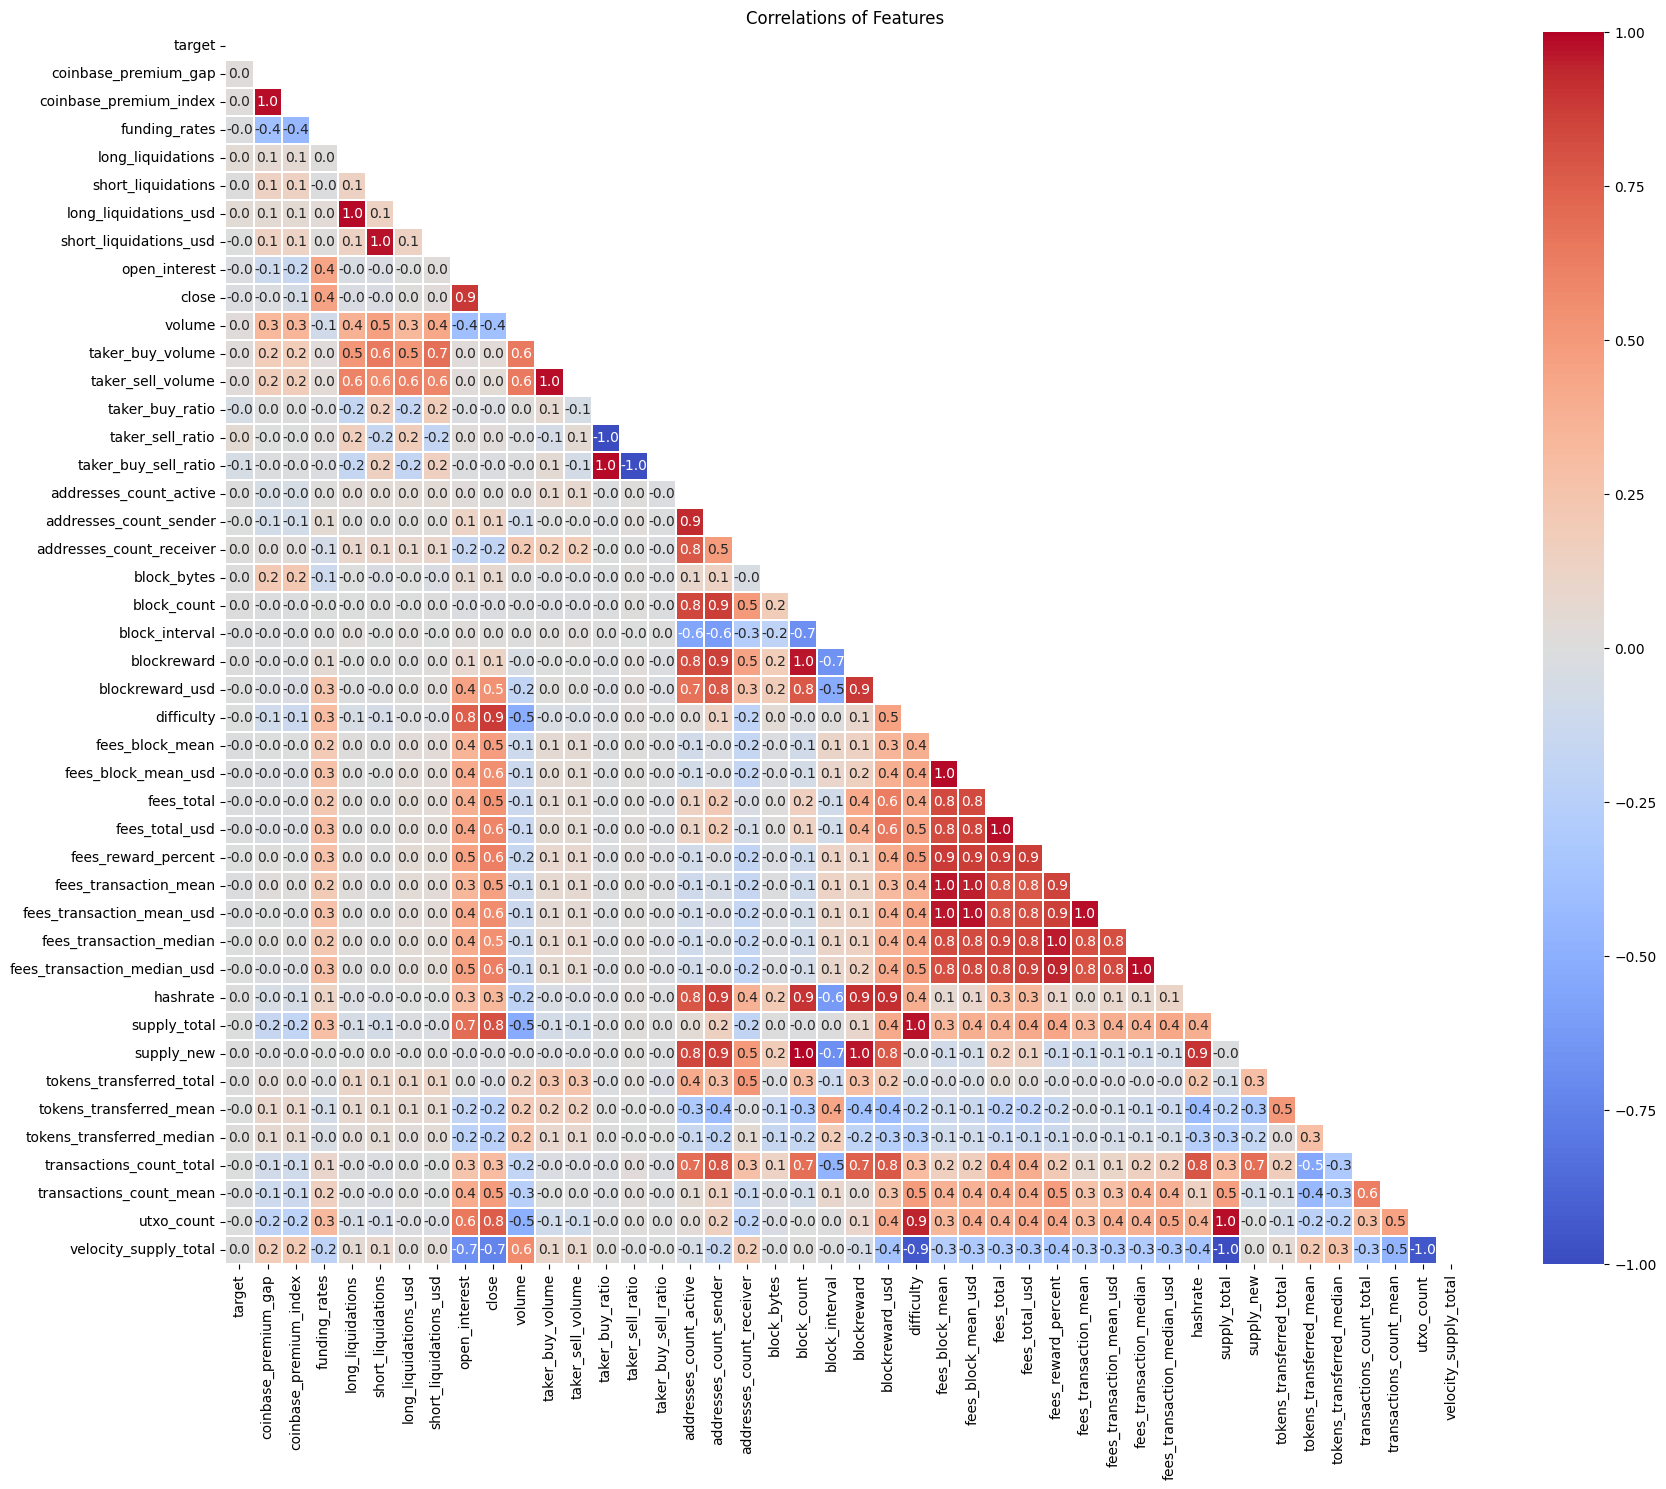

In [15]:
mask = np.zeros_like(corr_df)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(20, 16))
sns.heatmap(
    corr_df, 
    cmap='coolwarm', 
    annot=True, 
    fmt='.1f', 
    linewidth=0.2, 
    # square=True, 
    mask=mask
    )
plt.title('Correlations of Features')
plt.show()

### 데이터 시각화

In [16]:
# 이상치 탐색을 위해 boxplot을 이용한 시각화 코드 작성
fig: go.Figure = make_subplots(
    rows=7,
    cols=6,
    shared_xaxes=True,
    subplot_titles=[col for col in eda_df.columns]
)
px.box(data_frame = eda_df, x = 'target', y = 'close')

In [17]:
# eda_df에서 column별 outlier 개수 찾기
def find_outlier(
    df: pd.DataFrame,
    column: List[str]
) -> int:
    Q1 = df[column].describe()['25%']
    Q3 = df[column].describe()['75%']
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    lower_outlier = sum(df[column] < lower)
    upper_outlier = sum(df[column] > upper)
    count_outlier = lower_outlier + upper_outlier
    return count_outlier


find_outlier(eda_df, 'close')

1419

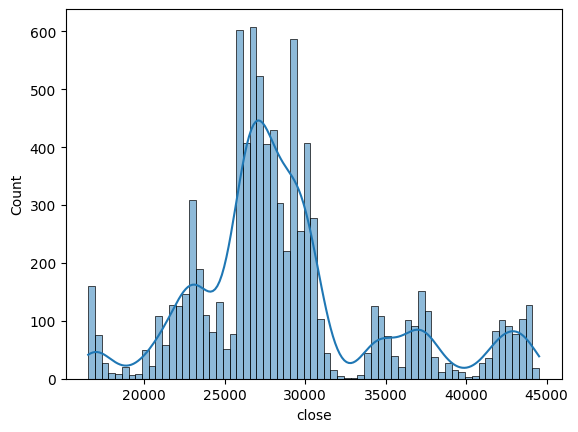

In [18]:
sns.histplot(data = eda_df['close'], kde=True)
plt.show()

In [19]:
sub_col = ['target', 'close', 'open_interest', 'difficulty', 'supply_total', 'utxo_count', 'velocity_supply_total']
# sns.pairplot(eda_df[sub_col], diag_kind = 'kde')
# plt.show()

px.scatter_matrix(eda_df, 
                  dimensions=sub_col, 
                  color='target'
)


In [20]:
# 결측치(missing value) 개수 count
eda_df.isnull().sum()

ID                              0
target                          0
coinbase_premium_gap            5
coinbase_premium_index          5
funding_rates                   0
long_liquidations               0
short_liquidations              0
long_liquidations_usd           0
short_liquidations_usd          0
open_interest                   0
close                           0
volume                          0
taker_buy_volume                0
taker_sell_volume               0
taker_buy_ratio                 0
taker_sell_ratio                0
taker_buy_sell_ratio            0
addresses_count_active          0
addresses_count_sender          0
addresses_count_receiver        0
block_bytes                    19
block_count                     0
block_interval                 19
blockreward                     0
blockreward_usd                 0
difficulty                     19
fees_block_mean                19
fees_block_mean_usd            19
fees_total                      0
fees_total_usd